In [8]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.9 MB/s eta 0:00:00


In [2]:
import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [3]:
def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image

In [4]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

In [5]:
def display_instances(image, mask, fname="test", figsize=(5, 5), blur=False, contour=True, alpha=0.5):
    fig = plt.figure(figsize=figsize, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax = plt.gca()

    N = 1
    mask = mask[None, :, :]
    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    margin = 0
    ax.set_ylim(height + margin, -margin)
    ax.set_xlim(-margin, width + margin)
    ax.axis('off')
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        _mask = mask[i]
        if blur:
            _mask = cv2.blur(_mask,(10,10))
        # Mask
        masked_image = apply_mask(masked_image, _mask, color, alpha)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        if contour:
            padded_mask = np.zeros((_mask.shape[0] + 2, _mask.shape[1] + 2))
            padded_mask[1:-1, 1:-1] = _mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8), aspect='auto')
    fig.savefig(fname)
    print(f"{fname} saved.")
    return

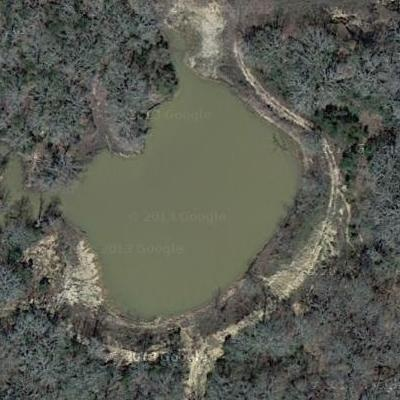

In [18]:
import requests
from PIL import Image

path = '/content/drive/MyDrive/Sat_image/test/River/1201.jpg'
image = Image.open(path)
image

In [20]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/dino-vits8", size=480)

In [21]:
pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 480, 480])


In [22]:
from transformers import ViTModel

model = ViTModel.from_pretrained("facebook/dino-vits8", add_pooling_layer=False)

In [23]:
# forward pass
outputs = model(pixel_values, output_attentions=True, interpolate_pos_encoding=True)

In [24]:
attentions = outputs.attentions[-1] # we are only interested in the attention maps of the last layer
nh = attentions.shape[1] # number of head

# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
print(attentions.shape)

torch.Size([6, 3600])


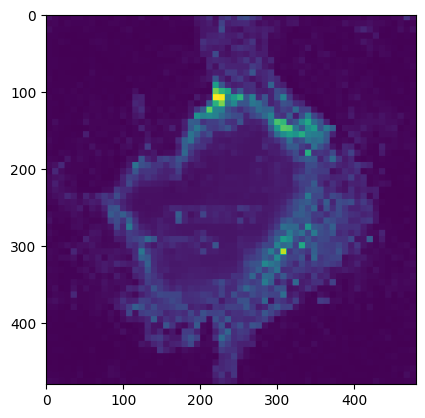

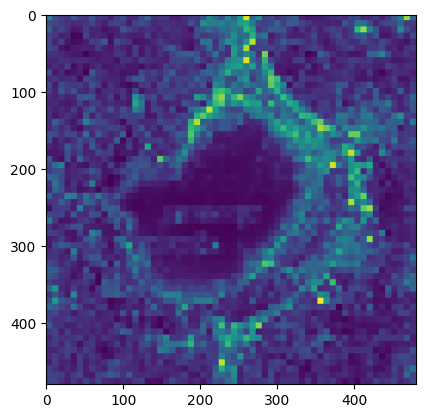

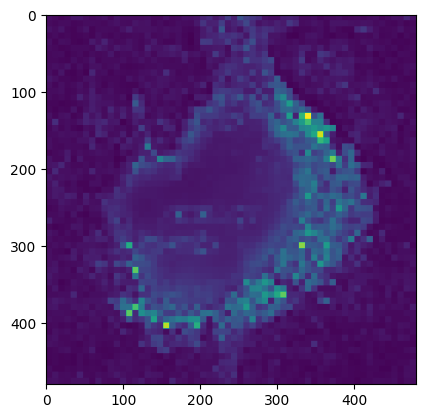

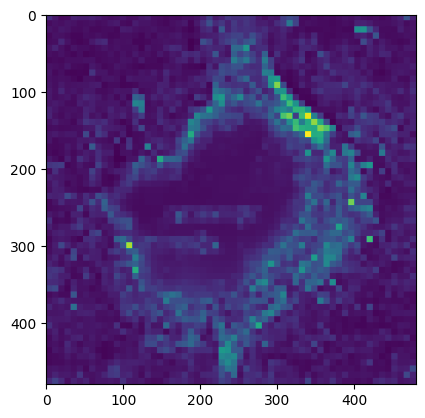

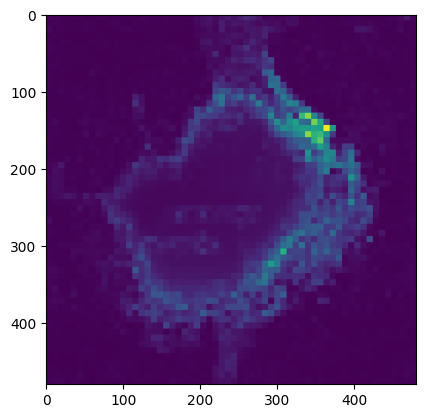

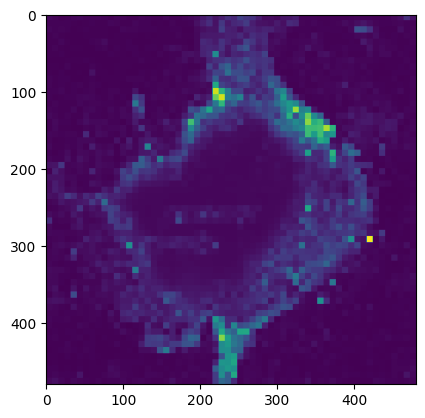

In [25]:
import os
import torch
import torch.nn as nn
import torchvision

threshold = 0.6
w_featmap = pixel_values.shape[-2] // model.config.patch_size
h_featmap = pixel_values.shape[-1] // model.config.patch_size


val, idx = torch.sort(attentions)
val /= torch.sum(val, dim=1, keepdim=True)
cumval = torch.cumsum(val, dim=1)
th_attn = cumval > (1 - threshold)
idx2 = torch.argsort(idx)
for head in range(nh):
    th_attn[head] = th_attn[head][idx2[head]]
th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=model.config.patch_size, mode="nearest")[0].cpu().numpy()

attentions = attentions.reshape(nh, w_featmap, h_featmap)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=model.config.patch_size, mode="nearest")[0].cpu()
attentions = attentions.detach().numpy()

output_dir = '.'
os.makedirs(output_dir, exist_ok=True)
torchvision.utils.save_image(torchvision.utils.make_grid(pixel_values, normalize=True, scale_each=True), os.path.join(output_dir, "img.png"))
for j in range(nh):
    fname = os.path.join(output_dir, "attn-head" + str(j) + ".png")
    plt.figure()
    plt.imshow(attentions[j])
    plt.imsave(fname=fname, arr=attentions[j], format='png')
    #print(f"{fname} saved.")